# Thermalization - Multiple Simulations

Text adapted from [1]: In [2, 3], Dawson demonstrated that, independently of the initial velocity distribution of the sheets, it is expected that over time the system will move towards thermal equilibrium, and that this happens due to crossings/collisions involving more than 2 sheets [2,3] . The distribution function of the sheet velocities is expected to converge to a normal distribution whose standard deviation corresponds to the thermal velocity of the plasma.

In this notebook we will show, using an average over multiple simulation for better statistics, that a system initialized using a waterbag distribution in velocity space thermalizes to the expected normal distribution. Additionally, we will show the increase in the entropy of the system when correlations between particles are estabilished (i.e. after crossings) using a diagnostic similar to the one introduced in [4]. We will be using solely the GNS due to run-time constraints.

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.1 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 447-448 <br>
[3] J. Dawson, Phys. Fluids 7.3 (1964) <br>
[4] H. Liang et al., Phys. Plasmas 26 (2019) - See App. A

In [1]:
import os
import sys
import jax
import numpy as np

from pathlib import Path
from scipy import stats 
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

# uncomment the line below for nicer plots (needs LaTeX)
os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

sys.path.append('../..')
from sheet_model.utils import get_relaxation_time, get_dx_eq, get_x_eq, moving_average
from gns.simulator import SMGNS

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Simulation Parameters

In [2]:
n_sheets = 1000
t_max = 300
boundary = 'periodic'

dx_eq = get_dx_eq(n_sheets) 
x_eq = get_x_eq(n_sheets)

# initial positions of charge sheets [1/L]
x0 = x_eq.copy()

# initial velocities
# the higher the initial value more time is needed to converge to a gaussian
vmax = 5 * dx_eq

## GNS

In [3]:
model_folder = Path(f'../../models/final/dt1e-1/4/')
gns = SMGNS(model_folder, boundary)

Simulator Info
   GNN model: ../../models/final/dt1e-1/4
   boundary: periodic
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


In [6]:
# for reproducibility
np.random.seed(42)

# perform multiple simulations of similar systems
N_SIMULATIONS = 50
V_SIM = []
XI_SIM = []
E_pot_ratio_SIM = []

for n in tqdm(range(N_SIMULATIONS)):
    
    v0 = np.random.uniform(-vmax, vmax, n_sheets)
    
    X, V, X_eq, E = gns.pred_rollout(x0,
                                     v0,
                                     x_eq,
                                     t_max=t_max,
                                     track_sheets=False,
                                     n_guards=0,
                                     verbose=False,
                                     np_=np)
    
    E_pot_ratio_SIM.append(0.5*np.mean(np.sum(np.square(X - X_eq),axis=-1)/E))
    V_SIM.append(V)
    XI_SIM.append(X-X_eq)
    
V_SIM = np.array(V_SIM)
XI_SIM = np.array(XI_SIM)
E_pot_ratio = np.mean(E_pot_ratio_SIM)
E_pot_ratio_SIM = np.array(E_pot_ratio_SIM)

  0%|          | 0/50 [00:00<?, ?it/s]

## Comparison between Theory and Fit

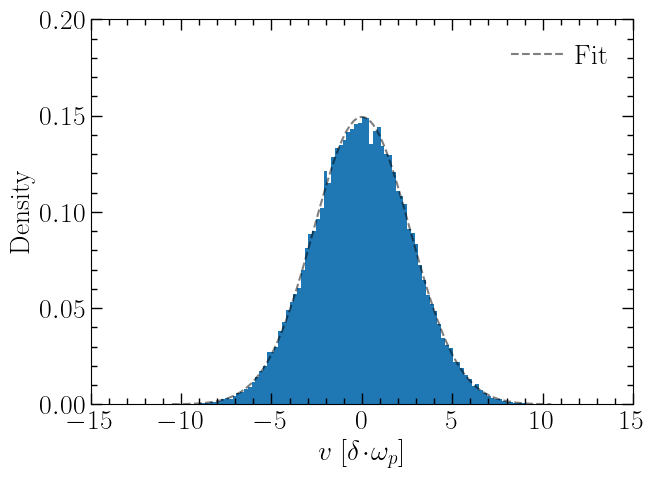

v_th_fit 2.6712551984861186
v_th_theory 2.678982870696674


In [7]:
plt.figure()

tframes = np.linspace(0, 10, 100)
tframes = np.concatenate([tframes, np.linspace(10, 300, 100)])
itframes = np.array(tframes/gns.dt_train, dtype=int)

_, bins, _ = plt.hist(V_SIM[:,itframes[-1]].flatten()/dx_eq, density=True, bins=100)
best_fit_line = stats.norm.pdf(bins, 0, np.std(V_SIM[:,-1])/dx_eq)
plt.plot(bins, best_fit_line, '--', color='k', alpha=0.5, label='Fit')
plt.xlim(-15, 15)
plt.ylim(0,0.2)
plt.xlabel('$v$ [$\delta\!\cdot\!\omega_p$]')
plt.ylabel('Density')
plt.legend()
plt.show()

v_th_fit =  np.std(V_SIM[:,-1])/dx_eq
# v_th = sqrt(1/3 v_0^2 * E_kin_ratio)
v_th_theory = np.sqrt(1/3 * (vmax/dx_eq)**2 * (1 - E_pot_ratio))
print('v_th_fit', v_th_fit)
print('v_th_theory', v_th_theory)

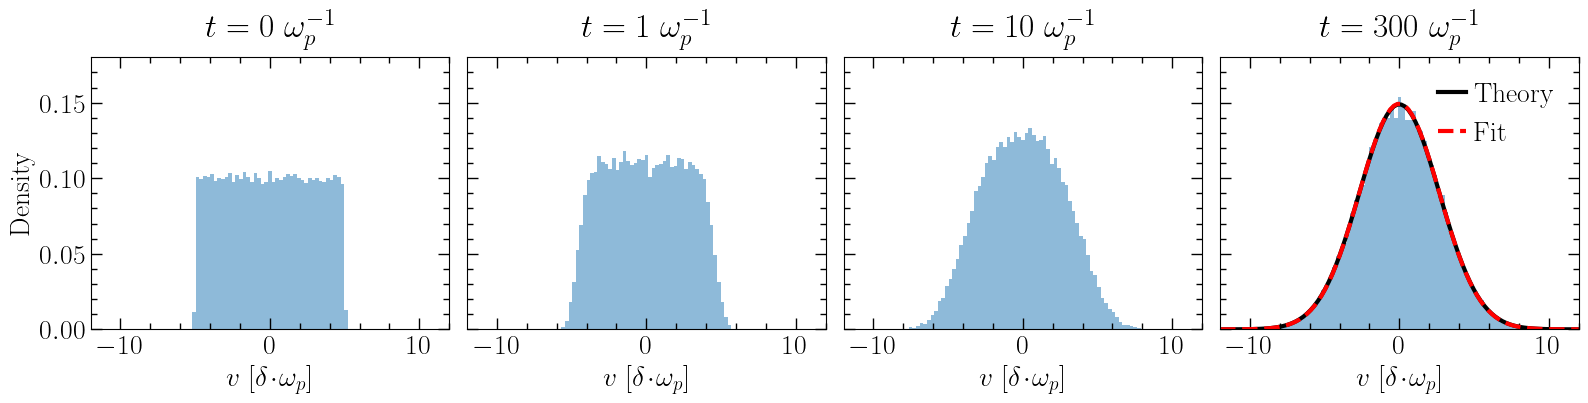

In [8]:
tframes = np.array([0, 1, 10, 300])
itframes = np.array(tframes/gns.dt_train, dtype=int)
bins = np.linspace(-12, 12, 100)

fig, ax = plt.subplots(1, len(tframes), figsize=(4*len(tframes), 4), 
                       gridspec_kw={'wspace':0.05, 'left':0.06, 'right':0.99, 'bottom':0.17, 'top': 0.85}, 
                       sharey=True, sharex=True)



for i, it in enumerate(itframes):
    
    ax[i].hist(V_SIM[:,it].flatten()/dx_eq, density=True, bins=bins, 
               alpha=0.5, rasterized=True)
    
    ax[i].set_title(f"$t = {tframes[i]:.0f} \ \omega_p^{{-1}}$", pad=15)
    ax[i].set_xlabel('$v$ [$\delta\!\cdot\!\omega_p$]')
    
    if i == len(itframes) - 1 :
        theoretical_line = stats.norm.pdf(bins, 0, v_th_theory)
        ax[i].plot(bins, theoretical_line, '-', color='k', lw=3, label='Theory')
        best_fit_line = stats.norm.pdf(bins, 0, v_th_fit)
        ax[i].plot(bins, best_fit_line, '--', color='r', lw=3, label='Fit')
        
ax[0].set_ylabel('Density')
plt.xlim(bins[0], bins[-1])
plt.ylim(0,0.18)
plt.legend(framealpha=0, loc='upper right', handlelength=1)
plt.savefig('../img/thermalization_multisim.pdf')
plt.show()

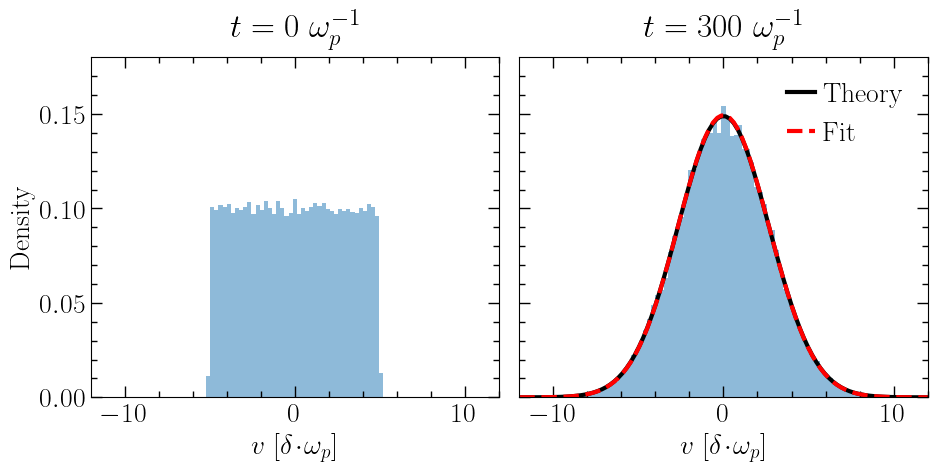

In [9]:
tframes = np.array([0, 300])
itframes = np.array(tframes/gns.dt_train, dtype=int)
bins = np.linspace(-12, 12, 100)

fig, ax = plt.subplots(1, len(tframes), figsize=(4.5*len(tframes), 5), 
                       gridspec_kw={'wspace':0.05, 'left':0.06, 'right':0.99, 'bottom':0.17, 'top': 0.85}, 
                       sharey=True, sharex=True)



for i, it in enumerate(itframes):
    
    ax[i].hist(V_SIM[:,it].flatten()/dx_eq, density=True, bins=bins, 
               alpha=0.5, rasterized=True)
    
    ax[i].set_title(f"$t = {tframes[i]:.0f} \ \omega_p^{{-1}}$", pad=15)
    ax[i].set_xlabel('$v$ [$\delta\!\cdot\!\omega_p$]')
    
    if i == len(itframes) - 1 :
        theoretical_line = stats.norm.pdf(bins, 0, v_th_theory)
        ax[i].plot(bins, theoretical_line, '-', color='k', lw=3, label='Theory')
        best_fit_line = stats.norm.pdf(bins, 0, v_th_fit)
        ax[i].plot(bins, best_fit_line, '--', color='r', lw=3, label='Fit')
        
ax[0].set_ylabel('Density')
plt.xlim(bins[0], bins[-1])
plt.ylim(0,0.18)
plt.legend(framealpha=0, loc='upper right', handlelength=1)
plt.savefig('../img/thermalization_multisim_two.pdf')
plt.show()

## Entropy Diagnostic

In [10]:
from sheet_model.utils import get_fdist, get_Sxv

def get_S_evolution(x, x_eq, v, xrange, vrange, bins):
    S = {'total': [], 'x':[], 'v':[]}
    FDIST = []
    for i in range(len(v)):
        fdist, _, _ = get_fdist(x[i], x_eq[i], v[i], xrange, vrange, bins=bins, normalize=False)
        s = get_Sxv(fdist)
        for k,sk in s.items():
            S[k].append(sk)
        FDIST.append(fdist)
    
    return S, FDIST

xrange = [-np.max(np.abs(XI_SIM))/dx_eq, np.max(np.abs(XI_SIM))/dx_eq]
vrange = [-np.max(np.abs(V_SIM))/dx_eq, np.max(np.abs(V_SIM))/dx_eq]

S, FDIST = get_S_evolution(np.einsum('ijk->jik', XI_SIM).reshape(XI_SIM.shape[1],-1)/dx_eq, 
                           np.zeros(XI_SIM.shape[1]), 
                           np.einsum('ijk->jik', V_SIM).reshape(V_SIM.shape[1],-1)/dx_eq, 
                           xrange, 
                           vrange, 
                           bins=51)

FDIST = np.array(FDIST)
FDIST_NORM = (np.sum(FDIST.reshape(FDIST.shape[0],-1), axis=-1) * (xrange[1]-xrange[0]) * (vrange[1] - vrange[0]))
FDIST /= FDIST_NORM.reshape(-1,1,1)
print('xi range:', -np.max(np.abs(XI_SIM))/dx_eq, np.max(np.abs(XI_SIM))/dx_eq)
print('v range:', -np.max(np.abs(V_SIM))/dx_eq, np.max(np.abs(V_SIM))/dx_eq)

xi range: -6.077945232391357 6.077945232391357
v range: -13.169819489121437 13.169819489121437


/tmp/ipykernel_151271/1477888842.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(ticks[:-1])
/tmp/ipykernel_151271/1477888842.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([0, None, 2])


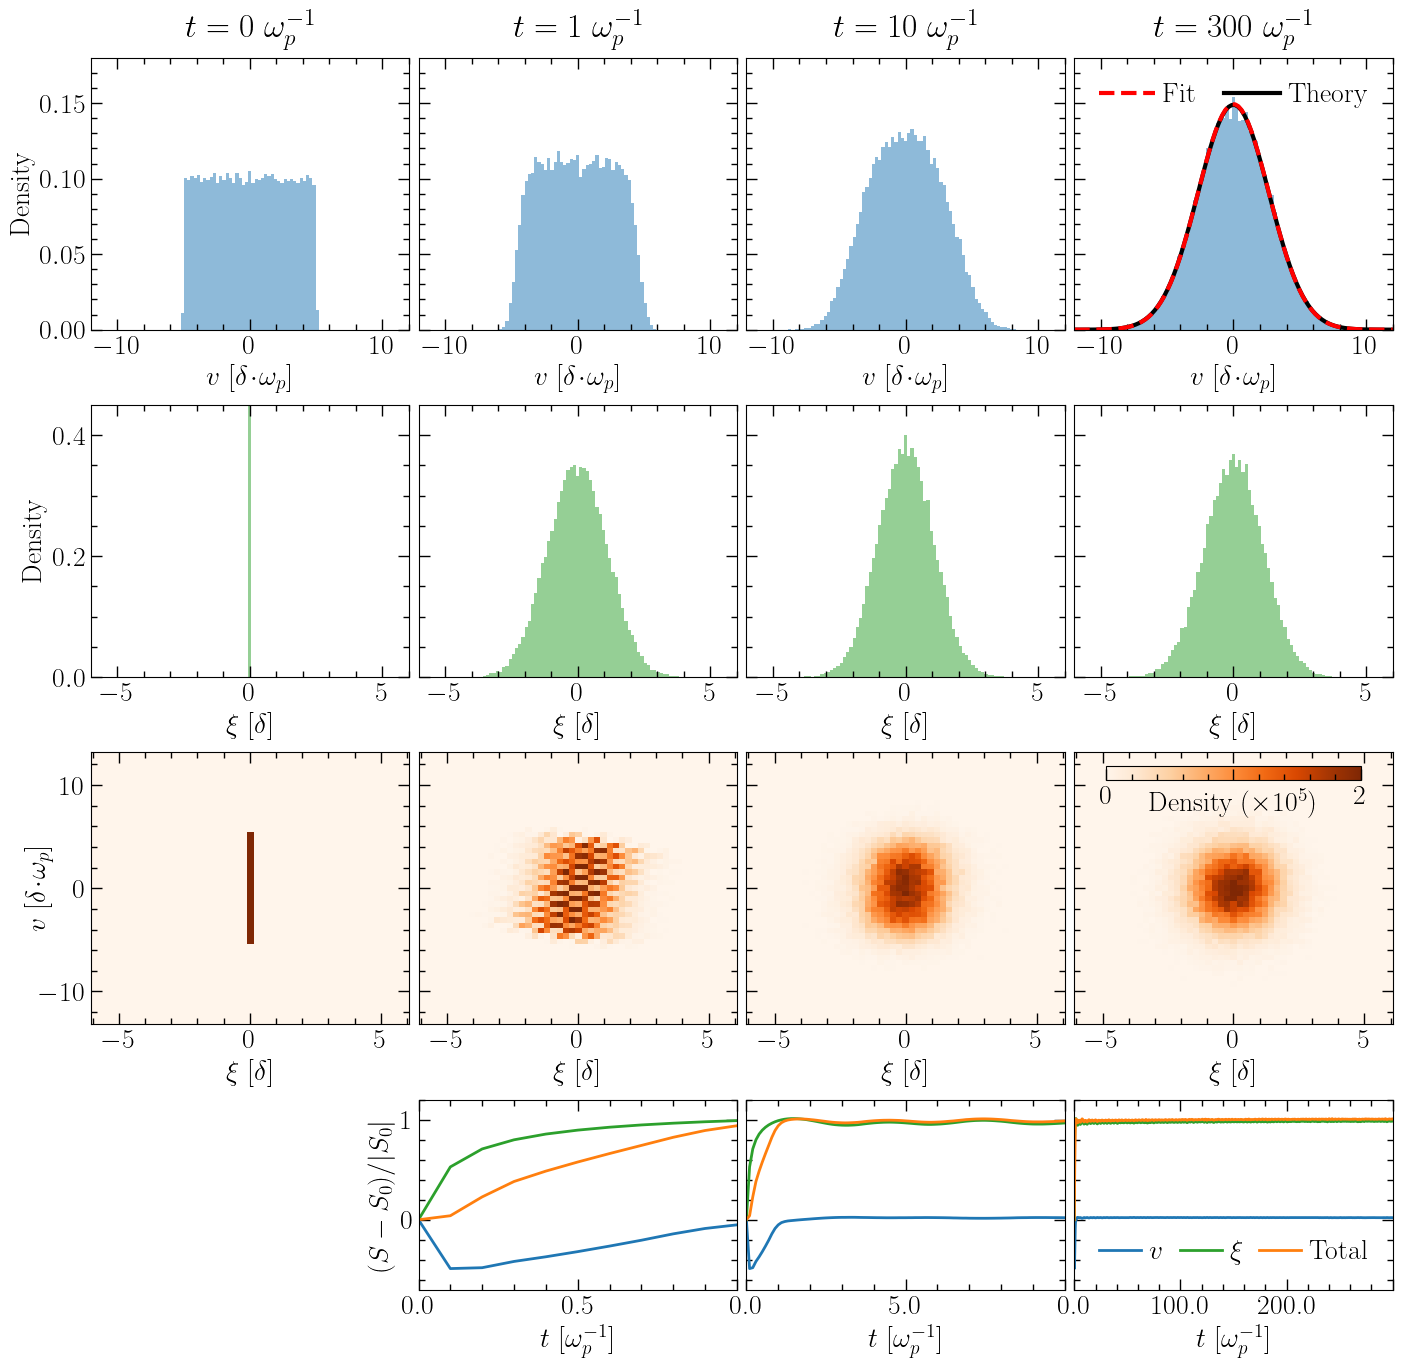

In [11]:
t = np.linspace(0, t_max, V_SIM.shape[1])
tframes = np.array([0, 1, 10, 300])
itframes = np.array(tframes/gns.dt_train, dtype=int)
bins = np.linspace(-12, 12, 100)
bins_xi = np.linspace(-6, 6, 100)

fig, ax = plt.subplots(4, len(tframes), figsize=(14, 14), 
                       gridspec_kw={'wspace':0.03, 'hspace':0.3, 
                                    'left':0.06, 'right':0.99, 'bottom':0.07, 'top': 0.95,
                                    'height_ratios': [1,1,1,0.7]},
                       sharey=False, sharex=False)



for i, it in enumerate(itframes):
    
    ax[0,i].hist(V_SIM[:,it].flatten()/dx_eq, density=True, bins=bins, 
                 alpha=0.5, rasterized=True, color='tab:blue')
    
    ax[1,i].hist(XI_SIM[:,it].flatten()/dx_eq, density=True, bins=bins_xi, 
                 alpha=0.5, rasterized=True, color='tab:green')
    
    im = ax[2,i].imshow(FDIST[it].T * 1e5, aspect='auto', origin='lower',
                   vmin=0, vmax=2, 
                   extent=[*xrange, *vrange], cmap='Oranges')
    
    if i != 0:
        ax[3,i].plot(t[:it+1], (S['v'][:it+1]-S['v'][0])/S['v'][0], lw=2, color='tab:blue', label='$v$')
        ax[3,i].plot(t[:it+1], (S['x'][:it+1]-S['x'][0])/S['v'][0], lw=2, color='tab:green', label=r'$\xi$')
        ax[3,i].plot(t[:it+1], (S['total'][:it+1]-S['total'][0])/S['total'][0], lw=2, color='tab:orange', label='Total')
        ax[3,i].set_xlim(0, t[it])
        
    ax[0,i].set_title(f"$t = {tframes[i]:.0f} \ \omega_p^{{-1}}$", pad=15)


theoretical_line = stats.norm.pdf(bins, 0, v_th_theory)
l1, = ax[0,-1].plot(bins, theoretical_line, '-', color='k', lw=3, label='Theory')
best_fit_line = stats.norm.pdf(bins, 0, v_th_fit)
l2, = ax[0,-1].plot(bins, best_fit_line, '--', color='r', lw=3, label='Fit')

#fig.colorbar(im, cax=ax[2, -1])

plt.setp(ax[0], xlabel='$v$ [$\delta\!\cdot\!\omega_p$]')
plt.setp(ax[1], xlabel=r'$\xi$ [$\delta$]')
plt.setp(ax[2], xlabel=r'$\xi$ [$\delta$]')
plt.setp(ax[3,1:], xlabel=r'$t$ [$\omega_p^{-1}$]')
plt.setp(ax[0], ylim=[0, 0.18])
plt.setp(ax[1], ylim=[0, 0.45])
plt.setp(ax[3], ylim=[-0.7, 1.2])
plt.setp(ax[0], xlim=[bins[0], bins[-1]])
plt.setp(ax[1], xlim=[bins_xi[0], bins_xi[-1]])
plt.setp(ax[:-1,1:], yticklabels=[])
plt.setp(ax[3,2:], yticklabels=[])

for a in ax[3,1:]:
    ticks = a.get_xticks()
    a.set_xticklabels(ticks[:-1])

ax[0,0].set_ylabel('Density')
ax[1,0].set_ylabel('Density')
ax[2,0].set_ylabel('$v$ [$\delta\!\cdot\!\omega_p$]', labelpad=-10)
ax[3,1].set_ylabel('$(S - S_0)/|S_0|$')
ax[3,0].axis('off')

ax[0,-1].legend(handles=[l2,l1], labels=['Fit', 'Theory'],
                framealpha=0, ncol=2, loc='upper right', mode='expand', handlelength=2)

ax[3,-1].legend(framealpha=0.7, ncol=3, mode='expand', loc='lower right', handlelength=1.5)
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cbaxes = inset_axes(ax[2,-1], width="80%", height="5%", loc='upper center')
cbar = fig.colorbar(im, cax=cbaxes, orientation='horizontal')
cbar.set_label(label=r'Density ($\times 10^5$)', size=20, labelpad=-15)
cbar.set_ticklabels([0, None, 2])


plt.savefig('../img/thermalization_multisim_entropy.pdf')
plt.show()

## Phase-space Animations

...............Done!


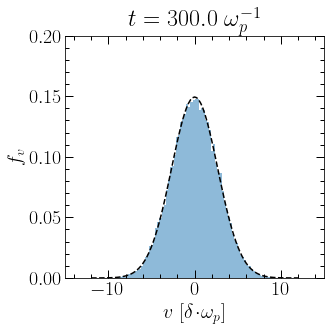

In [12]:
fps = 15
bins = np.linspace(-12, 12, 101)
tframes = np.linspace(0, 10, 100)
tframes = np.concatenate([tframes, np.linspace(10, 300, 100)])
itframes = np.array(tframes/gns.dt_train, dtype=int)

fig = plt.figure(figsize=(5,5))
best_fit_line = stats.norm.pdf(bins, 0, np.std(V_SIM[:,-1])/dx_eq)
_, bins, bar_container = plt.hist(V_SIM[:,0].flatten()/dx_eq, bins=bins, density=True, alpha=0.5)


ax = plt.gca()
ax.set_title(f"$t = 0.0 \ \omega_p^{{-1}}$")
plt.xlim(-15, 15)
plt.ylim(0, 0.2)
plt.ylabel('$f_v$')
plt.xlabel('$v$ [$\delta\!\cdot\!\omega_p$]')
plt.tight_layout()

def animate_func(i):
    if i % fps == 0:
        print('.', end='')
    
    if i == 100:
        plt.plot(bins, best_fit_line, '--', color='k')

    n, _ = np.histogram(V_SIM[:,itframes[i]].flatten()/dx_eq, bins, density=True)
    
    for count, rect in zip(n, bar_container.patches):
        rect.set_height(count)
        
    ax.set_title(f"$t = {tframes[i]:.1f} \ \omega_p^{{-1}}$")
        
    return bar_container.patches


anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = len(tframes),
                               interval = 1000 / fps)

anim.save('../img/thermalization.mp4', fps=fps)

print('Done!')

#frames 200
...............Done!


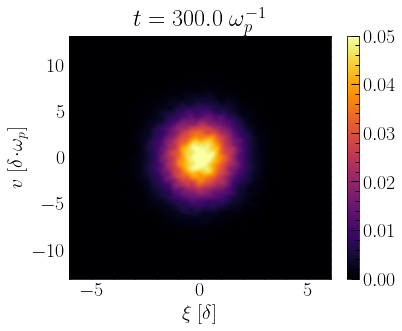

In [13]:
import matplotlib.animation as animation

XI_norm = np.einsum('ijk->jik', XI_SIM).reshape(XI_SIM.shape[1],-1)/dx_eq
V_norm = np.einsum('ijk->jik', V_SIM).reshape(V_SIM.shape[1],-1)/dx_eq

xrange = [-np.max(np.abs(XI_SIM))/dx_eq, np.max(np.abs(XI_SIM))/dx_eq] 
vrange = [-np.max(np.abs(V_SIM))/dx_eq, np.max(np.abs(V_SIM))/dx_eq]           

tframes = np.linspace(0, 10, 100)
tframes = np.concatenate([tframes, np.linspace(10, 300, 100)])
itframes = np.array(tframes/gns.dt_train, dtype=int)

fps = 15
frames = []
titles = []

bins = 61 # chosen odd number to center 0

for i in itframes:
    aux = get_fdist(XI_norm[i], 0, V_norm[i], xrange, vrange, bins=bins)[0]
    frames.append(aux)
    titles.append(gns.dt_train*i)
    
print('#frames', len(frames))
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6,5))

a = frames[0]
im = plt.imshow(a.T, interpolation='bicubic', aspect='auto', origin='lower',
                vmin=0, vmax=0.05, 
                extent=[*xrange, *vrange], cmap='inferno')

ax = plt.gca()
ax.set_title(f"$t = {titles[0]:.1f} \ \omega_p^{{-1}}$")
plt.ylabel('$v$ $[\delta\!\cdot\!\omega_p]$')
plt.xlabel(r'$\xi$ $[\delta]$')
plt.tight_layout()
plt.colorbar()

def animate_func(i):
    if i % fps == 0:
        print('.', end='')
    im.set_array(frames[i].T)
    ax.set_title(f"$t = {titles[i]:.1f} \ \omega_p^{{-1}}$")
    return [im]

anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               frames = len(frames),
                               interval = 1000 / fps)

anim.save('../img/thermalization_phasespace_multi.mp4', fps=fps)

print('Done!')

## Impact of the number of bins on the entropy diagnostic

The number of bins should not be very large (since otherwise there are not enough statistics) nor too small (otherwise the phasespace is not significantly partitioned). Nonetheless, we observe that the measured value of the relative variation of the entropy is quite stable for a wide range of values.

In [14]:
S_FINAL, S_0, BINS = [], [], []

for nbins in np.concatenate([np.arange(3,11,2), np.arange(11, 100, 10)]):
    
    fdist, _, _ = get_fdist(XI_SIM[:,-1].flatten()/dx_eq, 0, V_SIM[:,-1].flatten()/dx_eq, 
                            [-np.max(np.abs(XI_SIM))/dx_eq, np.max(np.abs(XI_SIM))/dx_eq], 
                            [-np.max(np.abs(V_SIM))/dx_eq, np.max(np.abs(V_SIM))/dx_eq], 
                            bins=int(nbins), normalize=False)
    
    s_final = get_Sxv(fdist)
    
    fdist, _, _ = get_fdist(XI_SIM[:,0].flatten()/dx_eq, 0, V_SIM[:,0].flatten()/dx_eq, 
                            [-np.max(np.abs(XI_SIM))/dx_eq, np.max(np.abs(XI_SIM))/dx_eq], 
                            [-np.max(np.abs(V_SIM))/dx_eq, np.max(np.abs(V_SIM))/dx_eq], 
                            bins=int(nbins), normalize=False)
    
    
    s0 = get_Sxv(fdist)
    
    S_FINAL.append(s_final)
    S_0.append(s0)
    BINS.append(nbins)
    
    print(f'n_bins: {int(nbins)}',
          f'\tn_sheets/n_bins: {int(n_sheets*N_SIMULATIONS/(nbins**2))}',
          f'\tdS/S0: {(s_final["total"] - s0["total"])/s0["total"]:.2f}',
          f'\tdS_x/S0: {(s_final["x"] - s0["x"])/s0["total"]:.2f}',
          f'\tdS_v/S0: {(s_final["v"] - s0["v"])/s0["total"]:.2f}')
    

n_bins: 3 	n_sheets/n_bins: 5555 	dS/S0: 0.52 	dS_x/S0: 0.64 	dS_v/S0: -0.12
n_bins: 5 	n_sheets/n_bins: 2000 	dS/S0: 0.62 	dS_x/S0: 0.77 	dS_v/S0: -0.14
n_bins: 7 	n_sheets/n_bins: 1020 	dS/S0: 1.02 	dS_x/S0: 0.97 	dS_v/S0: 0.05
n_bins: 9 	n_sheets/n_bins: 617 	dS/S0: 0.87 	dS_x/S0: 0.90 	dS_v/S0: -0.03
n_bins: 11 	n_sheets/n_bins: 413 	dS/S0: 0.91 	dS_x/S0: 0.92 	dS_v/S0: -0.01
n_bins: 21 	n_sheets/n_bins: 113 	dS/S0: 0.97 	dS_x/S0: 0.96 	dS_v/S0: 0.01
n_bins: 31 	n_sheets/n_bins: 52 	dS/S0: 0.99 	dS_x/S0: 0.97 	dS_v/S0: 0.02
n_bins: 41 	n_sheets/n_bins: 29 	dS/S0: 1.00 	dS_x/S0: 0.98 	dS_v/S0: 0.02
n_bins: 51 	n_sheets/n_bins: 19 	dS/S0: 1.01 	dS_x/S0: 0.99 	dS_v/S0: 0.02
n_bins: 61 	n_sheets/n_bins: 13 	dS/S0: 1.01 	dS_x/S0: 0.99 	dS_v/S0: 0.02
n_bins: 71 	n_sheets/n_bins: 9 	dS/S0: 1.02 	dS_x/S0: 1.00 	dS_v/S0: 0.02
n_bins: 81 	n_sheets/n_bins: 7 	dS/S0: 1.01 	dS_x/S0: 0.99 	dS_v/S0: 0.02
n_bins: 91 	n_sheets/n_bins: 6 	dS/S0: 1.01 	dS_x/S0: 0.99 	dS_v/S0: 0.02


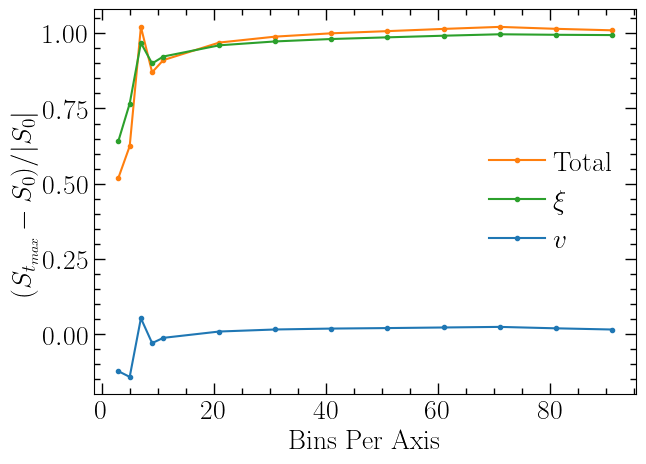

In [17]:
plt.plot(BINS, [(s['total'] - s0['total'])/s0['total'] for s,s0 in zip(S_FINAL, S_0)], '.-', color='tab:orange', label='Total')
plt.plot(BINS, [(s['x'] - s0['x'])/s0['total'] for s,s0 in zip(S_FINAL, S_0)], '.-', color='tab:green', label=r'$\xi$')
plt.plot(BINS, [(s['v'] - s0['v'])/s0['total'] for s,s0 in zip(S_FINAL, S_0)], '.-', color='tab:blue', label='$v$')
plt.xlabel('Bins Per Axis')
plt.ylabel('$(S_{t_{max}} - S_0)/|S_0|$')
plt.legend()
plt.show()